<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install fastai
!pip3 install Pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

データをダウンロードして，所定フォルダに展開する．

In [5]:
!mkdir data　#ディレクトリを作る．

mkdir: cannot create directory ‘data’: File exists


In [6]:
!mkdir data/mnist #その下にディレクトリを作る

mkdir: cannot create directory ‘data/mnist’: File exists


In [0]:
path = Path('data/mnist')

In [8]:
path.ls()

[PosixPath('data/mnist/mnist.pkl.gz')]

In [11]:
!wget  http://deeplearning.net/data/mnist/mnist.pkl.gz #ファイルをダウンロードする．

--2019-01-07 12:24:07--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  7.58MB/s    in 2.0s    

2019-01-07 12:24:09 (7.58 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
!mv mnist.pkl.gz data/mnist #上で作成したディレクトリに保管する．

圧縮ファイルを展開して，pickleファイルから訓練データと検証データを得る．

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

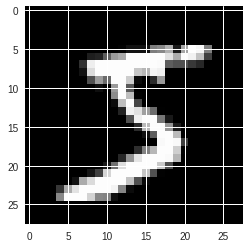

In [10]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [11]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)#バッチサイズは64

In [13]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic()

In [40]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [17]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [18]:
model(x).shape

torch.Size([64, 10])

In [19]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss() #損出関数を定義

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x) #ニューラルネットを前方計算し，yhatを求める
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward() #逆伝播で勾配を計算する
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

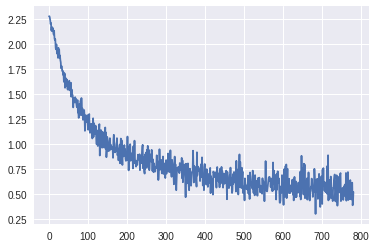

In [43]:
plt.plot(losses);

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

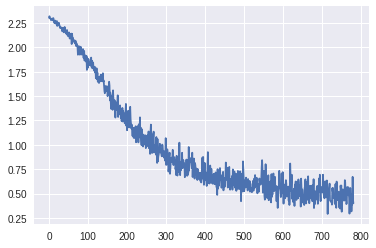

In [28]:
plt.plot(losses);

In [0]:
model = Mnist_NN()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

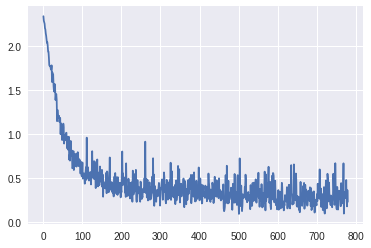

In [32]:
plt.plot(losses);

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


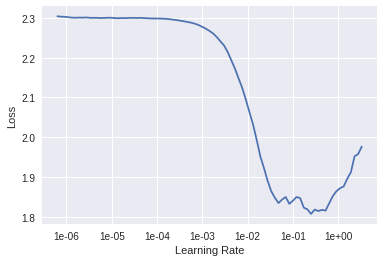

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.150248,0.130278,0.962900


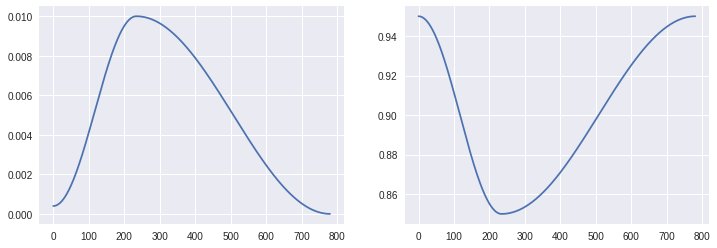

In [36]:
learn.recorder.plot_lr(show_moms=True)

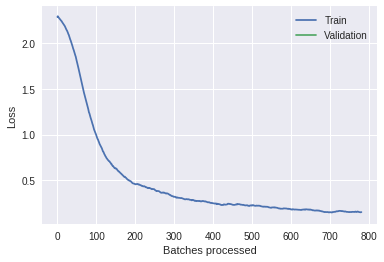

In [37]:
learn.recorder.plot_losses()

## fin